In [1]:
####### Challenge CISC 881 - Alice ###############
# pre processing 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import SimpleITK as sitk
import PIL
from PIL import Image

In [2]:
#Code snippets taken from the challenge files 

def readCsv(csvfname):
    # read csv to list of lists
    with open(csvfname, 'r') as csvf:
        reader = csv.reader(csvf)
        csvlines = list(reader)
    return csvlines

def readMhd(filename):
    # read mhd/raw image
    itkimage = sitk.ReadImage(filename)
    scan = sitk.GetArrayFromImage(itkimage) #3D image
    spacing = itkimage.GetSpacing() #voxelsize
    origin = itkimage.GetOrigin() #world coordinates of origin
    transfmat = itkimage.GetDirection() #3D rotation matrix
    return scan,spacing,origin,transfmat

def getImgWorldTransfMats(spacing,transfmat):
    # calc image to world to image transformation matrixes
    transfmat = np.array([transfmat[0:3],transfmat[3:6],transfmat[6:9]])
    for d in range(3):
        transfmat[0:3,d] = transfmat[0:3,d]*spacing[d]
    transfmat_toworld = transfmat #image to world coordinates conversion matrix
    transfmat_toimg = np.linalg.inv(transfmat) #world to image coordinates conversion matrix
    
    return transfmat_toimg,transfmat_toworld


def convertToImgCoord(xyz,origin,transfmat_toimg):
    # convert world to image coordinates
    xyz = xyz - origin
    xyz = np.round(np.matmul(transfmat_toimg,xyz))    
    return xyz
    
def normalizePlanes(npzarray):
    """
    Normalizing the image using the appropriate maximum and minimum values associated 
    with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
    """
    max_hu = 200.
    min_hu= -1000.
    npzarray = (npzarray - min_hu) / (max_hu - min_hu)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return (npzarray*255).astype(np.uint8)

In [23]:
#CHANGE YOUR DATA PATH 

datapath = 'D:/ChallengeData/'
from utils import readMhd, readCsv, getImgWorldTransfMats, convertToImgCoord
import xlrd
import xlwt
import csv

# Read nodules csv
csvlines = readCsv(datapath + 'trainNodules_gt.csv')
header = csvlines[0]
nodules = csvlines[1:]


wb = xlwt.Workbook()
ws = wb.add_sheet('Worksheet 1')
row = 0
lndloaded = -1
scan_idk = 0 

#create spacing file for karen to transfer things back to world coordinates 
wb_2 = xlwt.Workbook()
ws_2 = wb_2.add_sheet('Worksheet 1')
row = 0
ws_2.write(row, 0, "file number")
ws_2.write(row, 1, 'Spacing x')
ws_2.write(row, 2, 'Spacing y')
ws_2.write(row, 3, 'Spacing z')
ws_2.write(row, 4, 'origin x')
ws_2.write(row, 5, 'origin y')
ws_2.write(row, 6, 'origin z')
row_2 = 1

 #This part of the code that reads in the ground truth file and selects the slices with nodules from the 3D case 
# It saves a csv file with the new index information 
for n in nodules:
    print(n)
    ctr = np.array([float(n[header.index('x')]), float(n[header.index('y')]), float(n[header.index('z')])])
    lnd = int(n[header.index('LNDbID')])
    rads = list(map(int,list(n[header.index('RadID')].split(','))))
    radfindings = list(map(int,list(n[header.index('RadFindingID')].split(','))))
    finding = int(n[header.index('FindingID')])
    
    # Read scan
    if lnd!=lndloaded:
        scan_idk = 0 
        [scan,spacing,origin,transfmat] =  readMhd(datapath + 'data/LNDb-{:04}.mhd'.format(lnd))              
        transfmat_toimg,transfmat_toworld = getImgWorldTransfMats(spacing,transfmat)
        lndloaded = lnd
        ws_2.write(row_2, 0, lnd)
        ws_2.write(row_2, 1, spacing[0])
        ws_2.write(row_2, 2, spacing[1])
        ws_2.write(row_2, 3, spacing[2])
        ws_2.write(row_2, 4, origin[0])
        ws_2.write(row_2, 5, origin[1])
        ws_2.write(row_2, 6, origin[2])
        print(transfmat)
        row_2 += 1

    # Convert coordinates to image
    ctr = convertToImgCoord(ctr,origin,transfmat_toimg)  
    ws.write(row, 0, lnd) # number of the case 
    ws.write(row, 1, scan_idk) #number of the scan selected to label them when you have more than 1 slice selected 
    # from one case 
    scan_idk += 1 
    ws.write(row, 2, ctr[0])
    ws.write(row, 3, ctr[1])
    ws.write(row, 4, ctr[2])
    row += 1
    

    
wb.save(datapath + 'IndexNodules_2' + '.xls')
wb_2.save(datapath + 'CaseInformation' + '.xls')
    
    

['1', '1,2,3', '1,1,1', '1', '-44.20345052166667', '-119.07324219166667', '-37.5', '3', '1', '222.36069742736004', '5.0']
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
['1', '1', '2', '2', '25.8525390625', '-126.9697265625', '-45.5', '1', '1', '152.38103103637695', '4.0']
['2', '1,2,3', '1,1,3', '1', '88.8955078125', '-123.86751302083333', '-129.5', '3', '1', '378.04229736328125', '5.0']
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
['2', '1,3', '2,2', '2', '63.5341796875', '-112.7568359375', '-117.5', '2', '1', '174.84456253051758', '5.0']
['2', '1,3', '3,5', '3', '-103.8505859375', '-116.7421875', '-253.0', '2', '1', '297.708309173584', '5.0']
['2', '1', '4', '4', '67.8818359375', '-95.3662109375', '-81.5', '1', '1', '54.081050872802734', '3.0']
['2', '1', '5', '5', '44.6943359375', '-123.6259765625', '-63.5', '1', '1', '22.052467346191406', '4.0']
['2', '2', '2', '6', '117.8798828125', '-121.4521484375', '-209.5', '1', '1', '14.137166941154069', '5.0']
['2', '3', '1', '7', '87.44628

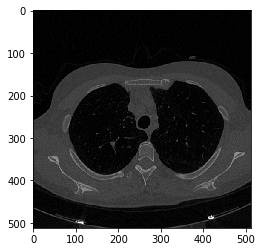

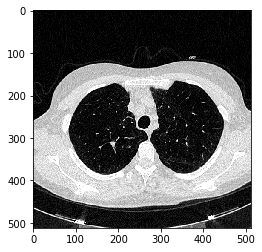

In [27]:
#Visualize contrast enhancement 
img = sitk.ReadImage(datapath + 'data/LNDb-0001.mhd')
img_arr = sitk.GetArrayFromImage(img)

plt.imshow(img_arr[260], cmap=plt.cm.gray)
plt.show()

img_correct = normalizePlanes(img_arr)
plt.imshow(img_correct[260], cmap=plt.cm.gray)
plt.show()

In [31]:
from PIL import Image
# Transform scans into jpg images for the Detector processing 
csvlines = readCsv(datapath + 'IndexNodules.csv')
header = csvlines[0]
nodules = csvlines[1:]

lndloaded = -1
num=0
for scan in nodules : 
    # Read scan
    lnd = int(scan[header.index('Index')])
    if lnd!=lndloaded:
        num = 0
        img =  sitk.ReadImage(datapath + 'data/LNDb-{:04}.mhd'.format(lnd))              
        img_arr = sitk.GetArrayFromImage(img)
        img_arr = (normalizePlanes(img_arr)) #normalize and the values to get sharper images 
        lndloaded = lnd
    
    img_slice = img_arr[int(scan[header.index('Z')])]
    im = Image.fromarray(img_slice)
    filename = datapath + 'data_pics/LNDb-{:04}'.format(lnd) + '_' + str(num) + '.jpg'
    print(filename)
    im.save(datapath + 'data_pics/LNDb-{:04}'.format(lnd) + '_' + str(num) + '.jpg')
    num += 1

D:/ChallengeData/data_pics/LNDb-0001_0.jpg
D:/ChallengeData/data_pics/LNDb-0001_1.jpg
D:/ChallengeData/data_pics/LNDb-0002_0.jpg
D:/ChallengeData/data_pics/LNDb-0002_1.jpg
D:/ChallengeData/data_pics/LNDb-0002_2.jpg
D:/ChallengeData/data_pics/LNDb-0002_3.jpg
D:/ChallengeData/data_pics/LNDb-0002_4.jpg
D:/ChallengeData/data_pics/LNDb-0002_5.jpg
D:/ChallengeData/data_pics/LNDb-0002_6.jpg
D:/ChallengeData/data_pics/LNDb-0002_7.jpg
D:/ChallengeData/data_pics/LNDb-0003_0.jpg
D:/ChallengeData/data_pics/LNDb-0003_1.jpg
D:/ChallengeData/data_pics/LNDb-0003_2.jpg
D:/ChallengeData/data_pics/LNDb-0003_3.jpg
D:/ChallengeData/data_pics/LNDb-0003_4.jpg
D:/ChallengeData/data_pics/LNDb-0004_0.jpg
D:/ChallengeData/data_pics/LNDb-0004_1.jpg
D:/ChallengeData/data_pics/LNDb-0004_2.jpg
D:/ChallengeData/data_pics/LNDb-0005_0.jpg
D:/ChallengeData/data_pics/LNDb-0005_1.jpg
D:/ChallengeData/data_pics/LNDb-0007_0.jpg
D:/ChallengeData/data_pics/LNDb-0007_1.jpg
D:/ChallengeData/data_pics/LNDb-0008_0.jpg
D:/Challeng